# Figure 3

In [1]:
## Tree figure rendering
import os
from os import path
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

In [2]:
import sys
sys.path.insert(1, '../code/scripts')

In [4]:
## Basics
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import mdtraj as md
import parseaf as pa
#import tempparse as paf

## Logistic regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499'}

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [6]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [7]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

In [8]:
def get_cnf_freq(cnf_mat):
    cnf_freq = cnf_mat / cnf_mat.sum(axis=1)[:, np.newaxis]
    return cnf_freq

## Data

In [9]:
allregions = pd.read_csv('../data/af_regions/sc_af_regions_all.csv')

In [10]:
cnf_df = pd.read_csv('../misc/cp_cnf_matrices.csv')

## 3A: Logistic regression model coefficients

In [11]:
states = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [12]:
for aa in states:
    allregions['freq_'+aa] = allregions.apply(lambda row: append_percent_aa(row, aa), axis=1)

In [13]:
featurecol = []
for aa in states:
    featurecol.append('freq_'+aa)
X = allregions[featurecol]
y = allregions['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
cnf_all = metrics.confusion_matrix(y_test, y_pred)
metrics.accuracy_score(y_test, y_pred)

0.9246841593780369

In [14]:
df_lr = pd.DataFrame(columns=['aa','coef'])
for i in range(20):
    df_lr = df_lr.append({'aa': states[i], 'coef': logreg.coef_[0][i]}, ignore_index=True)
df_lr = df_lr.sort_values(by='coef', ascending=False, key=abs)

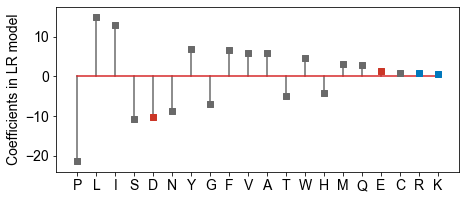

In [44]:
plt.figure(figsize=(6.7,3))
plt.stem(df_lr['aa'], df_lr['coef'],
         linefmt='dimgrey')

for index,row in df_lr.iterrows():
    aa = row['aa']
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
    else:
        color = 'dimgrey'
    plt.scatter(aa, row['coef'], marker='s', color=color, zorder=3)
    
plt.ylabel('Coefficients in LR model')
plt.tight_layout()
plt.savefig('./plots/Figure3.3A.png', dpi=300)
plt.show()

## 3B: LR coefficients against helix propensity

In [18]:
df_hp = pd.read_csv('../data/misc/helix_propensity_pace1998.txt')
h_propensity = {}
for index, row in df_hp.iterrows():
    h_propensity[row['aa']] = row['hp']

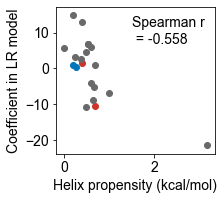

In [19]:
plt.figure(figsize=(3.3,3))

coefs = logreg.coef_.tolist()[0]
for i in range(20):
    aa = states[i]
    if aa == 'K' or aa == 'R':
        color = cscheme['pos']
    elif aa == 'D' or aa == 'E':
        color = cscheme['neg']
    else:
        color = 'dimgrey'
    plt.scatter(h_propensity[aa], coefs[i],
                color=color, zorder=3)

plt.xlabel('Helix propensity (kcal/mol)')
plt.ylabel('Coefficient in LR model')
corr = stats.spearmanr(list(h_propensity.values()), logreg.coef_[0].tolist())
plt.text(1.5, 7, "Spearman r\n = " + '{0:.3g}'.format(corr.correlation))
plt.tight_layout()
#plt.savefig('./fig.png', dpi=300)
plt.savefig('./plots/Figure3.3B.png', dpi=300)
plt.show()

## 3C: Uversky plot for all regions

In [20]:
df = pd.read_csv('../data/uversky/uversky_all.csv')

In [21]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Helix',
                          markerfacecolor=cscheme['helix'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Disordered',
                          markerfacecolor=cscheme['dis'], markersize=10)]

<Figure size 216x216 with 0 Axes>

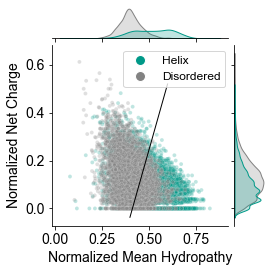

In [22]:
plt.figure(figsize=(3,3))
g = sns.jointplot(data=df, x='norm_hydrop', y='norm_nc', hue='label',
                  palette={'disordered': cscheme['dis'], 'helix': cscheme['helix']},
                  alpha=0.25, s=15, height=4, legend=False)
x = np.linspace(0.4,0.6,100)
y = 2.785*x - 1.151
g.ax_joint.plot(x, y, 'black', linewidth = 1)
g.ax_joint.set_xlabel('Normalized Mean Hydropathy')
g.ax_joint.set_ylabel('Normalized Net Charge')
#g.legend.set_title(None)

#h,l = g.get_legend_handles_labels()
#plt.legend(h[1:],l[1:])

plt.legend(handles=legend_elements, fontsize=12,
           bbox_to_anchor=(-0.1,1))
plt.tight_layout()
plt.savefig('./plots/Figure3.3C.png', dpi=300)
plt.show()

## 3D: Accuracy of logistic regression model

In [23]:
cnf_matrices = []
sample_size = []
for index, row in cnf_df.iterrows():
    mat = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]])
    cnf_matrices.append(mat)
    if index < 3:
        sample_size.append(row['n'])

In [24]:
titles = ['Purely helical\nand disordered\nregions',
          'Randomly\ndrawn\nregions',
          'Highly\ncharged\nregions']
#for i, title in enumerate(titles):
#    titles[i] = title + '\nn = ' + str(sample_size[i])

In [25]:
cnf_matrices

[array([[2258,  183],
        [ 127, 1548]]), array([[2422,  128],
        [ 385,  980]]), array([[489,  21],
        [ 74, 199]]), array([[7698, 1884],
        [2181, 4701]]), array([[1948,  602],
        [ 529,  836]]), array([[510,   0],
        [271,   2]])]

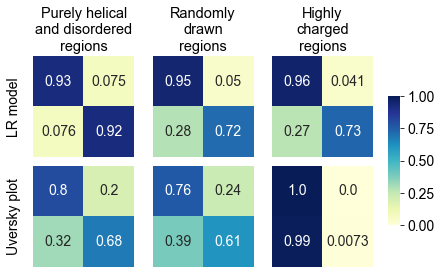

In [28]:
fig, axes = plt.subplots(2,3, figsize=(5.5, 4))
cbar_ax = fig.add_axes([1, .2, .03, .45])

for i, ax in enumerate(axes.flat):
    g = sns.heatmap(pd.DataFrame(get_cnf_freq(cnf_matrices[i])), ax=ax,
                    square=True, annot=True, fmt=".2",
                    xticklabels=['', ''], yticklabels=['', ''],
                    cmap="YlGnBu", cbar= (i == 0),
                    vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)
    g.tick_params(left=False, bottom=False)
    if i < 3:
        g.set_title(titles[i], fontsize=14.5)
    #ax.title.set_position([.5, 0.8])
    if i == 0:
        ax.set_ylabel('LR model')
        ax.yaxis.labelpad = 5
    elif i == 3:
        ax.set_ylabel('Uversky plot')
        ax.yaxis.labelpad = 5
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()
plt.savefig('./plots/Figure3.3D.png', dpi=300)

## 3E: Summary of prediction accuracy for 3D

In [30]:
l_acc = []
for i in range(6):
    cnf = cnf_matrices[i]
    accuracy = (cnf[0, 0] + cnf[1, 1]) / np.sum(cnf)
    l_acc.append(accuracy)
sc_acc = np.mean(l_acc[:3])

In [34]:
ticks = ['LR model,\nall regions',
         'LR model,\nrandomly drawn regions',
         'LR model,\nhighly charged regions',
         'Uverskey plot,\nall regions',
         'Uverskey plot,\nrandomly drawn regions',
         'Uverskey plot,\nhighly charged regions']

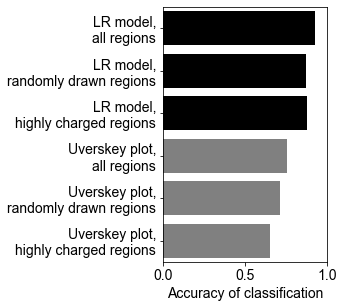

In [37]:
fig, ax = plt.subplots(figsize=(5,4.5))
ax = sns.barplot(y=ticks, x=l_acc,
                 palette=['black', 'black', 'black', 'grey', 'grey', 'grey'])
ax.set_xlim(0, 1)
ax.set_xlabel('Accuracy of classification')
plt.tight_layout()
plt.savefig('./plots/Figure3.3E.png', dpi=300)
plt.show()

## 3F: Prediction accuracy for other training or testing data

In [38]:
d_acc = {'sc_onlyP': 0.7468415937803693,
 'sc_onlyPG': 0.7560738581146744,
 'sc_top5': 0.8965014577259475,
 'pombe': 0.9080121057661675,
 'human': 0.9397504456327985}

In [39]:
d_acc

{'sc_onlyP': 0.7468415937803693,
 'sc_onlyPG': 0.7560738581146744,
 'sc_top5': 0.8965014577259475,
 'pombe': 0.9080121057661675,
 'human': 0.9397504456327985}

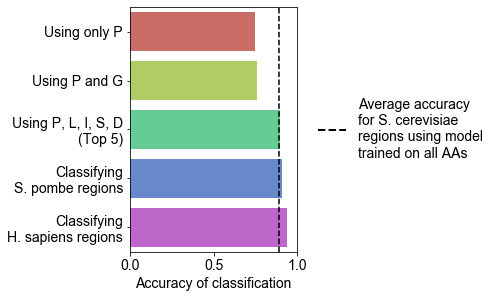

In [43]:
fig, ax = plt.subplots(figsize=(3,4.5))
keys = list(d_acc.keys())
vals = [d_acc[k] for k in keys]
ax = sns.barplot(y=keys, x=vals, palette="hls")
ax.set_yticklabels(['Using only P', 'Using P and G','Using P, L, I, S, D\n(Top 5)', 
                    'Classifying\nS. pombe regions',
                    'Classifying\nH. sapiens regions'])
ax.set_xlabel('Accuracy of classification')
ax.set_xlim(0, 1)
plt.axvline(sc_acc, color='black', linestyle='dashed')
plt.legend([Line2D([0], [0], color='black', lw=2, ls='dashed')],
           ['Average accuracy\nfor S. cerevisiae\nregions using model\ntrained on all AAs'],
          bbox_to_anchor=(1.05, 0.68), frameon=False)

plt.tight_layout()
plt.savefig('./plots/Figure3.3F.png', dpi=300, bbox_inches='tight')
plt.show()

## 3G: Time Tree

In [56]:
from Bio import Phylo
from ete3 import Tree, NodeStyle, TreeStyle

ModuleNotFoundError: No module named 'ete3'

In [57]:
t = Tree('../data/misc/timetree.nwk', format=1)

NameError: name 'Tree' is not defined

In [31]:
for n in t.traverse("postorder"):
    if len(n.name) > 4:
        n.name = n.name.replace("_", " ")

In [32]:
ts = TreeStyle()
ts.show_leaf_name = True
ts.scale_length = 300

I plan to make this in inkscape instead because for some reason the branches don't align in